<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Moscow</h1>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

<h2 style='color:blue'>Загрузка датасета</h2>

In [5]:
df1 = pd.read_csv("moscow_apartment_prices.csv")
df1.head()

,price,house_age,dist_to_subway,subway_type,lat,lon,rooms,footage,floor,max_floor,area,material
0,8000000,42,960,0.0,55.609009,37.734632,1,39.4,11,12,UAO,panel
1,7200000,43,802,0.0,55.608760,37.741936,1,35.6,2,9,UAO,panel
2,10300000,43,638,0.0,55.610207,37.742495,2,53.0,5,12,UAO,panel
3,8500000,43,929,0.0,55.624017,37.740373,2,44.1,8,9,UAO,panel
4,9000000,43,785,0.0,55.609107,37.740430,2,44.2,6,9,UAO,panel


In [4]:
df1.to_csv("moscow_apartment_prices.csv", index=False)

In [8]:
df1.shape

(12107, 12)

In [9]:
df1.columns

Index(['price', 'house_age', 'dist_to_subway', 'subway_type', 'lat', 'lon',
       'rooms', 'footage', 'floor', 'max_floor', 'area', 'material'],
      dtype='object')

In [10]:
df1.isnull().sum()

,0
price,0
house_age,0
dist_to_subway,0
subway_type,0
lat,0
lon,0
rooms,0
footage,0
floor,0
max_floor,0


<h2 style='color:blue'Очистка данныхs</h2>

<h2 style='color:blue'>Feature Engineering</h2>

Для покупателей часто важно, является ли этаж последним или первым. Добавим этот признак:

In [11]:
df1['is_first_floor'] = (df1['floor'] == 1).astype(int)
df1['is_last_floor'] = (df1['floor'] == df1['max_floor']).astype(int)

Широта и долгота не так содержательны, как расстояние до центра города, поэтому посчитаем его:

In [12]:
center_lat = 55.7
center_lon = 37.6

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Apply the Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance
df1['distance_to_center'] = df1.apply(lambda row: haversine(row['lat'], row['lon'], center_lat, center_lon), axis=1)

df1.head()

,price,house_age,dist_to_subway,subway_type,lat,lon,rooms,footage,floor,max_floor,area,material,is_first_floor,is_last_floor,distance_to_center
0,8000000,42,960,0.0,55.609009,37.734632,1,39.4,11,12,UAO,panel,0,0,13.179674
1,7200000,43,802,0.0,55.608760,37.741936,1,35.6,2,9,UAO,panel,0,0,13.498719
2,10300000,43,638,0.0,55.610207,37.742495,2,53.0,5,12,UAO,panel,0,0,13.401513
3,8500000,43,929,0.0,55.624017,37.740373,2,44.1,8,9,UAO,panel,0,0,12.202625
4,9000000,43,785,0.0,55.609107,37.740430,2,44.2,6,9,UAO,panel,0,0,13.407425


In [13]:
df2 = df1.drop(['lat','lon'],axis='columns')
df2.shape

(12107, 13)

In [14]:
df2.dtypes

,0
price,int64
house_age,int64
dist_to_subway,int64
subway_type,float64
rooms,int64
footage,float64
floor,int64
max_floor,int64
area,object
material,object


**Анализ категориальных признаков**

In [15]:
len(df2['area'].unique()), len(df2['material'].unique())

(9, 4)

In [16]:
df2['area'].value_counts()

,count
area,
UVAO,2053
ZAO,1594
UAO,1496
UZAO,1453
SAO,1422
VAO,1362
SVAO,1314
SZAO,760
CAO,653


In [17]:
df2['material'].value_counts()

,count
material,
panel,5698
brick,2469
monolith,2378
block,1562


Хотя признак subway_type имеет числовые значения, на самом деле он является категориальным, тк нет отношения порядка на типах транспорта. Наверно метро и МЦК лучше, чем МЦД, но явного отношения порядка между метро и МЦК нет.

In [76]:
df2['subway_type'] = df2['subway_type'].astype(int).astype(str)
df2['subway_type'].value_counts()

,count
subway_type,
0,10448
2,1075
1,584


<h2 style="color:blue">Удаление выбросов на основе знания о сфере</h2>

Средняя площадь одной комнаты: от 14 до 20 кв.метров в зависимости от типа квартиры.

In [77]:
df2['rooms'].value_counts()

,count
rooms,
2,7295
1,4812


In [78]:
footage_per_room = df2['footage']/df2['rooms']

(array([1.224e+03, 3.868e+03, 3.049e+03, 2.996e+03, 6.030e+02, 2.360e+02,
        8.900e+01, 3.000e+01, 1.000e+01, 2.000e+00]),
 array([15.5 , 21.63, 27.76, 33.89, 40.02, 46.15, 52.28, 58.41, 64.54,
        70.67, 76.8 ]),
 <BarContainer object of 10 artists>)

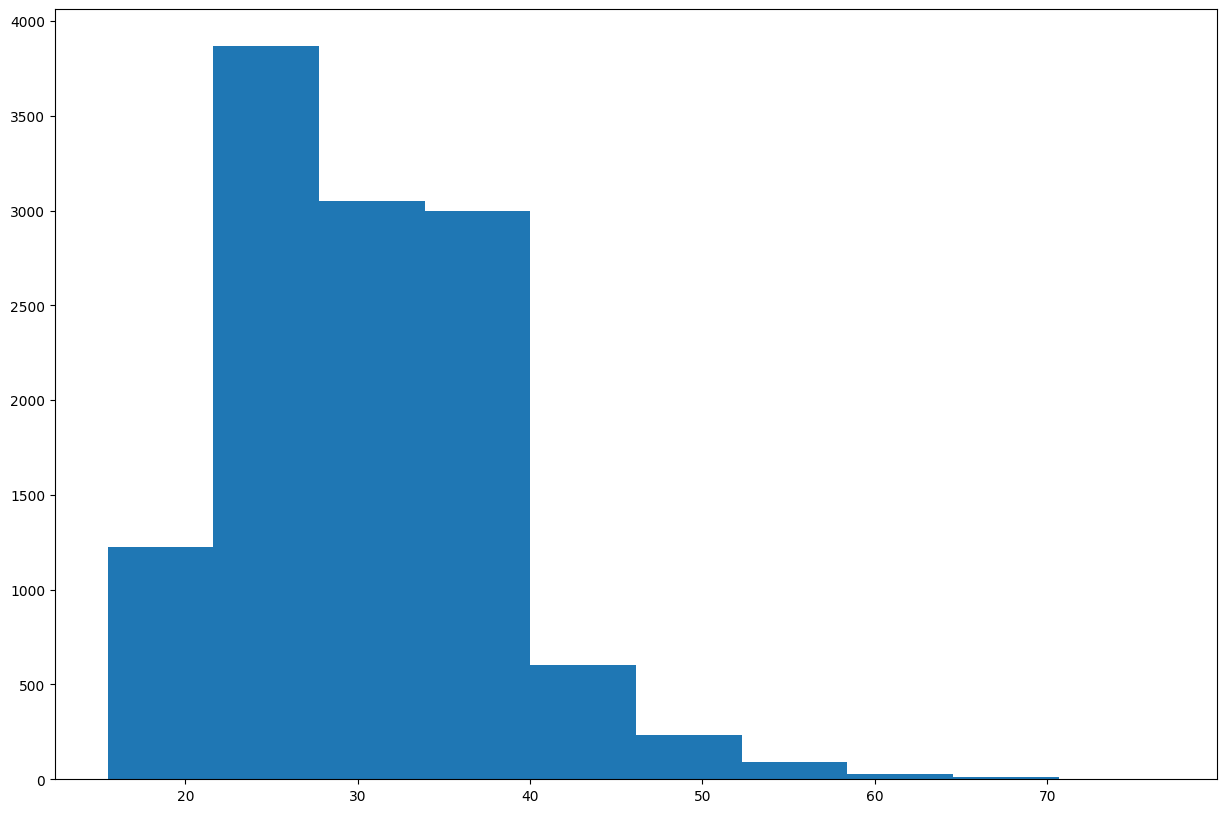

In [79]:
plt.hist(footage_per_room)

Учитывая, что в датасете есть только 1комнатные и 2комнатные квартиры, то в данном распределении не прослеживается выбросов

По цене и другим параметрам квартиры довольно обычные, так что вряд ли комнаты там могут быть такими большими.

<h2 style='color:blue'>Удаление выбросов на основе статистики по столбцам</h2>

In [80]:
df2.describe()

,price,house_age,dist_to_subway,rooms,footage,floor,max_floor,is_first_floor,is_last_floor,distance_to_center
count,1.210700e+04,12107.000000,12107.000000,12107.000000,12107.000000,12107.000000,12107.000000,12107.000000,12107.000000,12107.000000
mean,1.086765e+07,36.281325,930.639795,1.602544,46.169305,6.877509,13.463286,0.104815,0.094326,12.503003
std,3.039930e+06,21.419519,533.029215,0.489392,10.552497,5.317597,6.417366,0.306328,0.292293,5.377530
min,4.900000e+06,0.000000,11.000000,1.000000,30.100000,1.000000,2.000000,0.000000,0.000000,0.465987
25%,8.500000e+06,16.000000,550.000000,1.000000,38.000000,3.000000,9.000000,0.000000,0.000000,8.912190
50%,1.020000e+07,42.000000,826.000000,2.000000,44.500000,5.000000,12.000000,0.000000,0.000000,12.042033
75%,1.270000e+07,54.000000,1180.000000,2.000000,53.500000,9.000000,17.000000,0.000000,0.000000,16.632288
max,2.000000e+07,130.000000,2988.000000,2.000000,89.900000,38.000000,39.000000,1.000000,1.000000,27.200814


Видно, что в датасете есть очень старые дома (до 130 лет), но 75%-квантиль это 54 года. Так как далее планируется использовать линейную регрессию, такие большие значения могут негативно сказаться на обучении.

(array([2424., 1659., 1478., 2866., 3334.,  181.,   99.,   48.,    9.,
           9.]),
 array([  0.,  13.,  26.,  39.,  52.,  65.,  78.,  91., 104., 117., 130.]),
 <BarContainer object of 10 artists>)

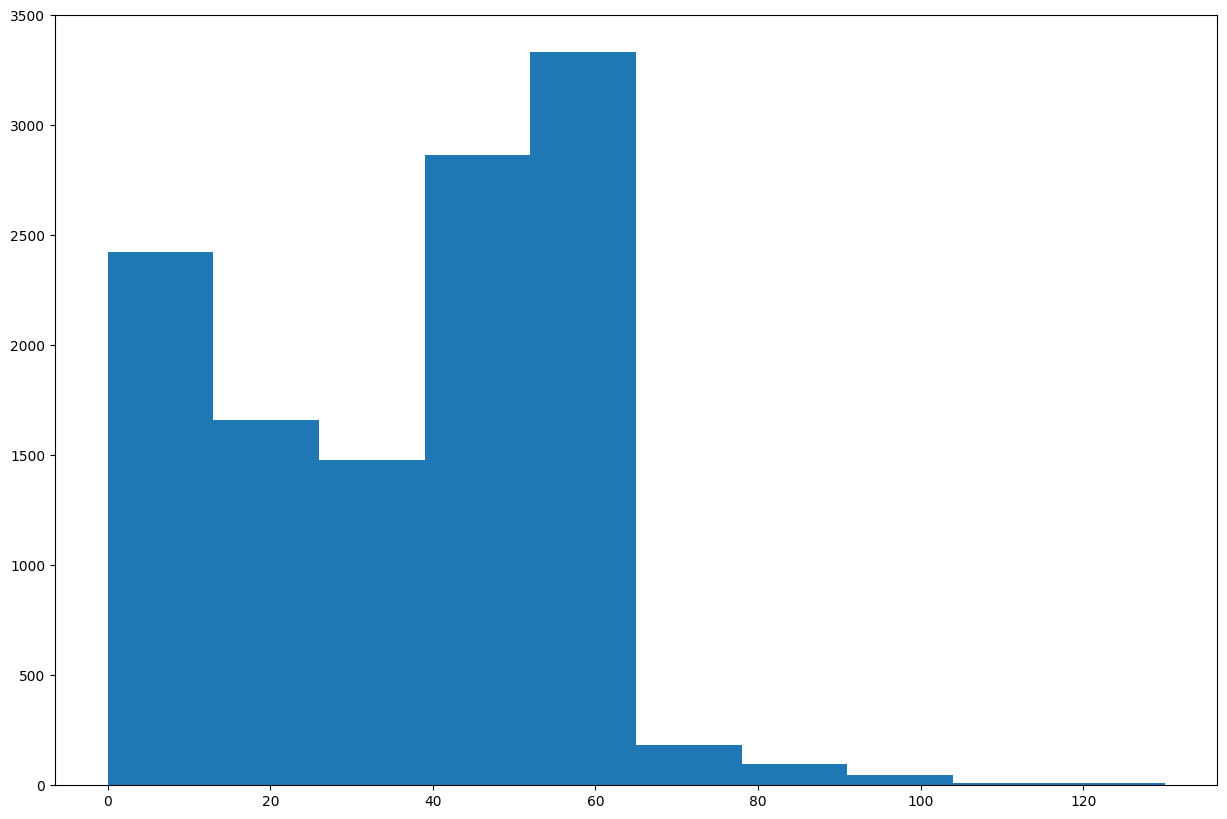

In [81]:
plt.hist(df2['house_age'])

In [82]:
(df2['house_age'] >= 65).sum() / len(df2['house_age'])

0.0285785083009829

In [83]:
len(df2)

12107

In [84]:
m = np.mean(df2['house_age'])
st = np.std(df2['house_age'])
df3 = df2[(df2['house_age'] > (m - 1.5*st)) & (df2['house_age'] <= (m + 1.5*st))]

In [85]:
len(df3)

10482

Аналогично уберем квартиры с выделяющимися значениями max_floor

In [86]:
m = np.mean(df3['max_floor'])
st = np.std(df3['max_floor'])
df4 = df3[(df3['max_floor'] > (m - 1.5*st)) & (df3['max_floor'] <= (m + 1.5*st))]

In [87]:
len(df4)

9439

**Теперь посмотрим на графики цены квартиры относительно площади**

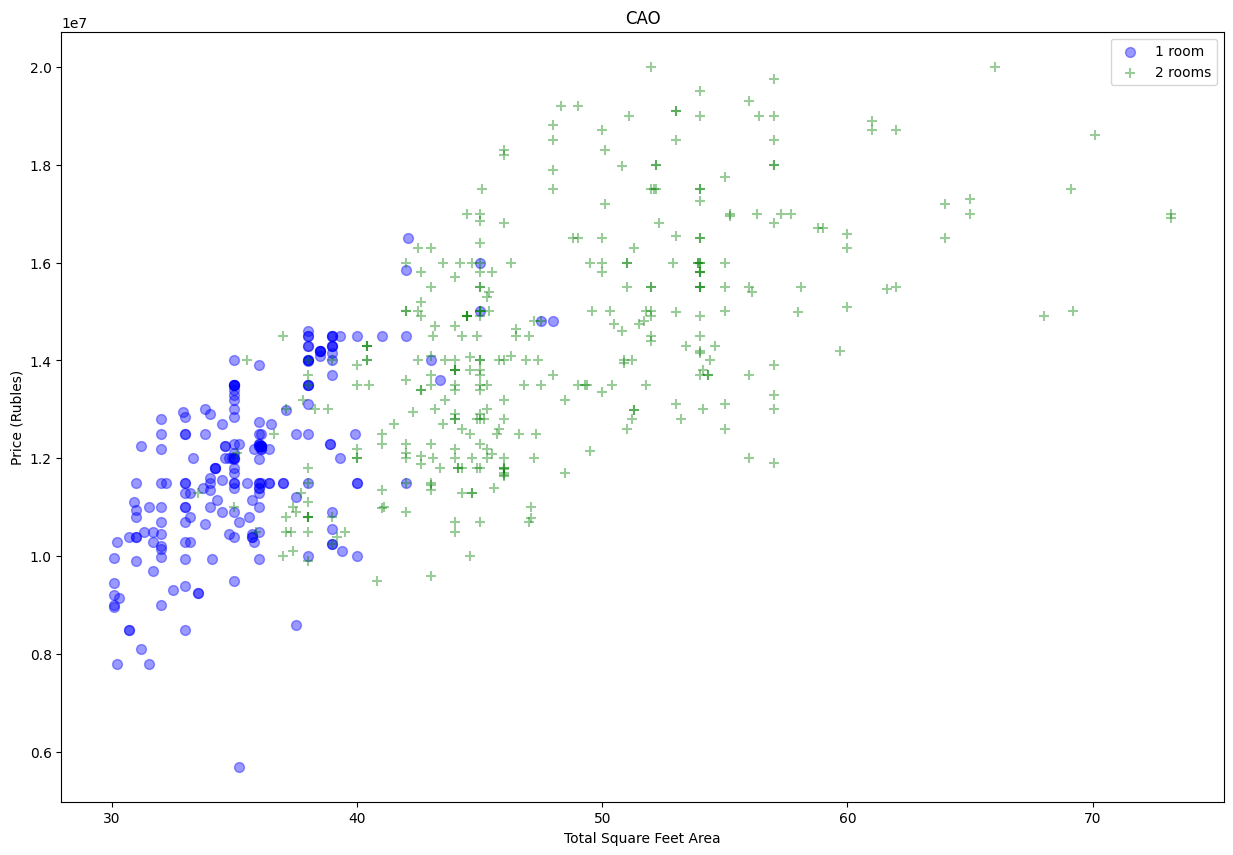

In [88]:
def plot_scatter_chart(df, ax, area):
    rooms2 = df[(df.area==area) & (df.rooms==2)]
    rooms1 = df[(df.area==area) & (df.rooms==1)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    ax.scatter(rooms1.footage, rooms1.price,color='blue',label='1 room', s=50, alpha=0.4)
    ax.scatter(rooms2.footage, rooms2.price,marker='+', color='green',label='2 rooms', s=50,  alpha=0.4)
    ax.set_xlabel("Total Square Feet Area")
    ax.set_ylabel("Price (Rubles)")
    ax.set_title(area)
    ax.legend()
fig, ax = plt.subplots()
plot_scatter_chart(df4,ax, "CAO")

Посмотрим на остальные графики:

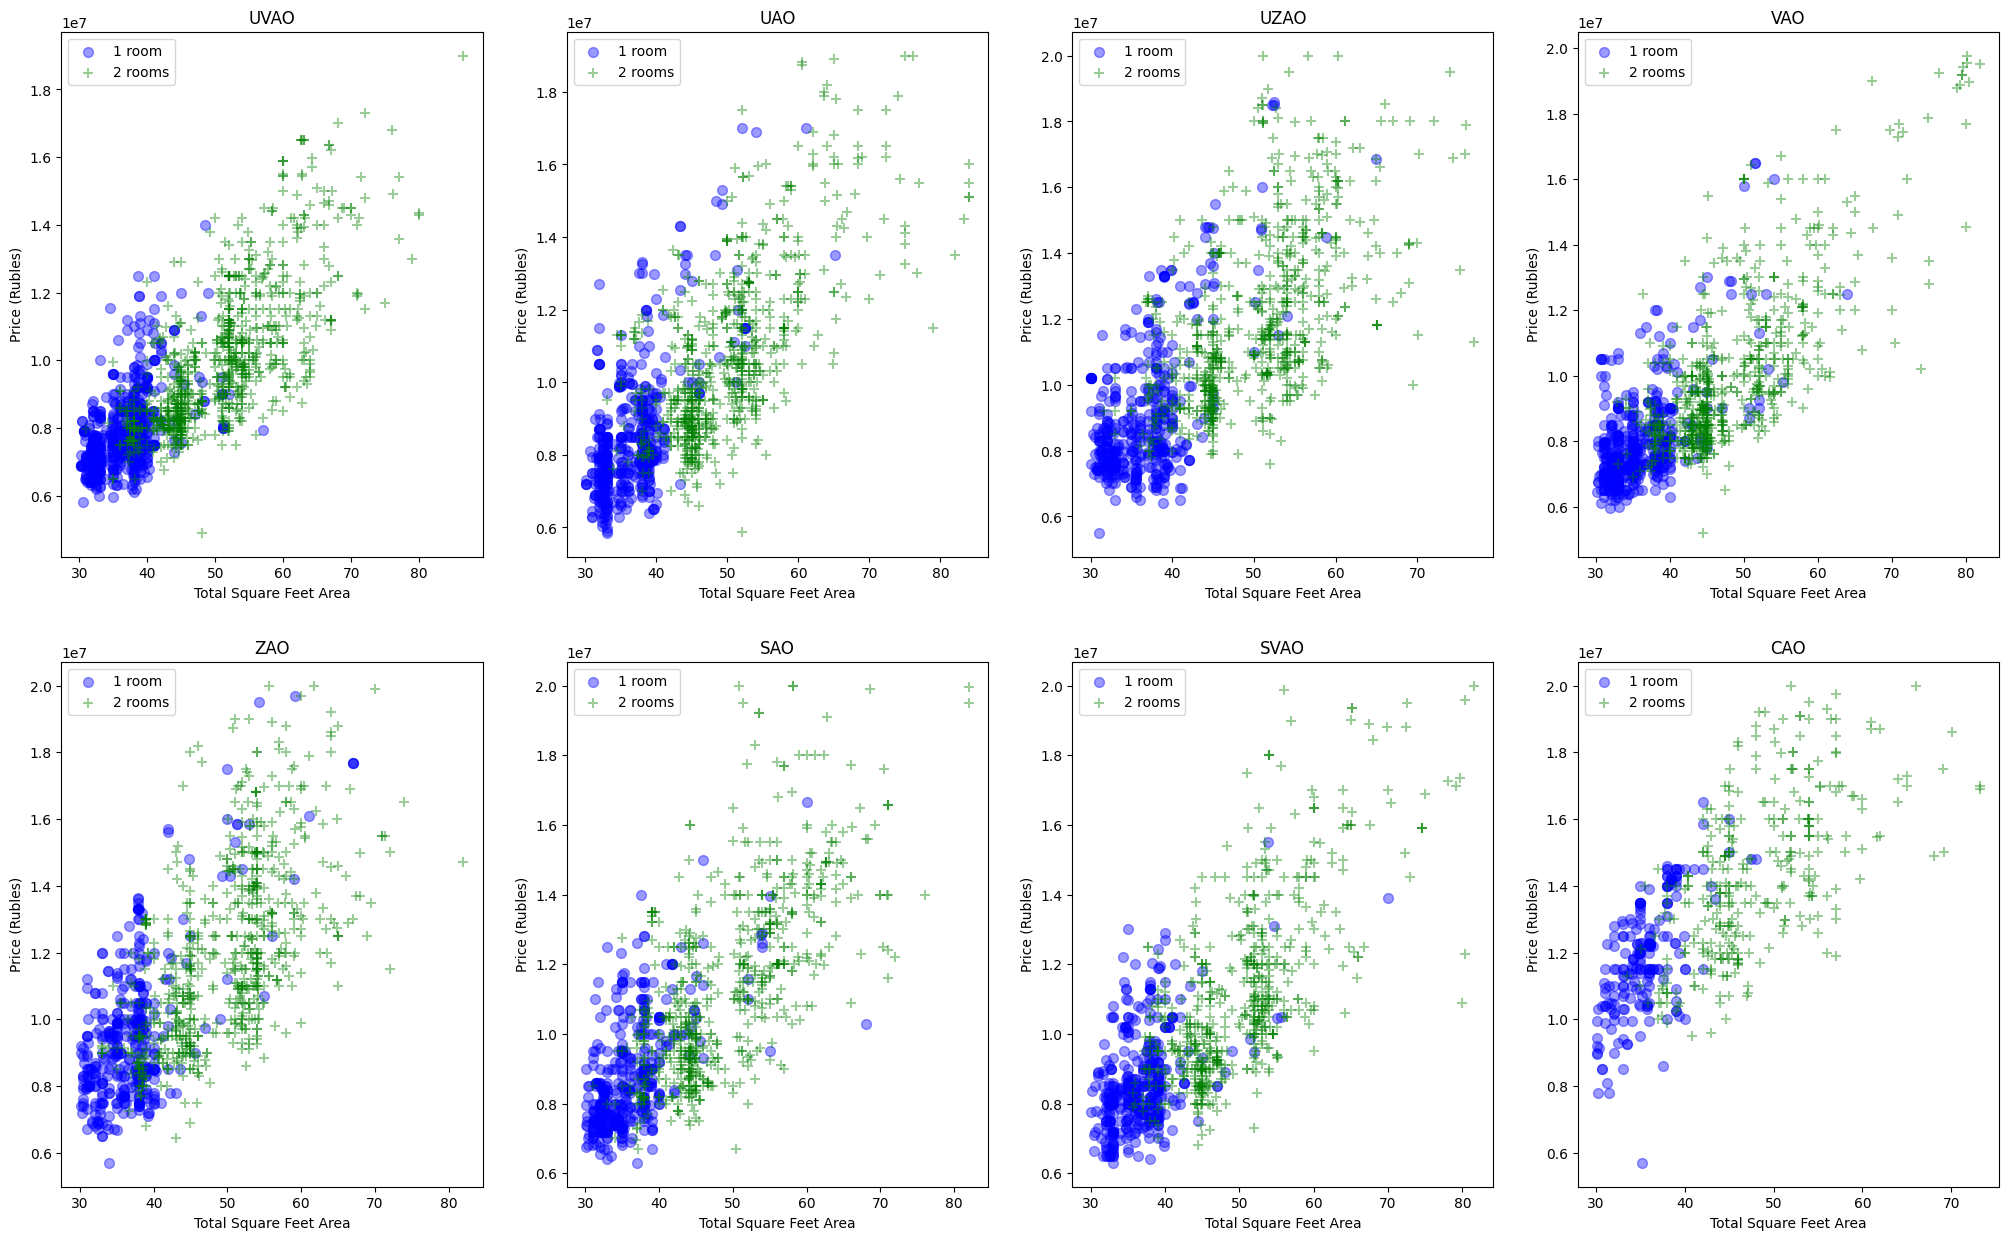

In [89]:
fig, axs = plt.subplots(2, 4, figsize=(25, 15))
regions = df4['area'].value_counts().index[:-1]
for i, region in enumerate(regions):
    ax = axs[i // 4, i % 4]
    plot_scatter_chart(df4, ax, region)

plt.show()

Также заметны выбросы, когда, например, точка для однокомнатной квартиры сильно выбивается из общего кластера и наоборот. Поэтому уберём однокомнатные и двухкомнатные квартиры, которые выбиваются из общей массы по цене за квадратный метр

In [90]:
df4.loc[:, 'price_per_meter'] = df4['price'] / df4['footage']

df5 = pd.DataFrame()

for (area, rooms), group in df4.groupby(['area', 'rooms']):
    m = np.mean(group['price_per_meter'])
    st = np.std(group['price_per_meter'])
    filtered_group = group[(group['price_per_meter'] > (m - 1.2*st)) & (group['price_per_meter'] <= (m + 1.2*st))]
    df5 = pd.concat([df5, filtered_group])

In [91]:
df6 = df5.drop('price_per_meter',axis='columns')
df6.shape

(7540, 13)

<h2 style='color:blue'>One Hot Encoding для категориальных признаков</h2>

In [92]:
df6.columns

Index(['price', 'house_age', 'dist_to_subway', 'subway_type', 'rooms',
       'footage', 'floor', 'max_floor', 'area', 'material', 'is_first_floor',
       'is_last_floor', 'distance_to_center'],
      dtype='object')

In [93]:
categorical_columns = ['area', 'material', 'subway_type']

In [94]:
dummies = pd.get_dummies(df6[categorical_columns]).astype(int)
df7 = pd.concat([df6, dummies], axis='columns')
df8 = df7.drop(categorical_columns, axis='columns')
df8.head(2)

,price,house_age,dist_to_subway,rooms,footage,floor,max_floor,is_first_floor,is_last_floor,distance_to_center,...,area_UZAO,area_VAO,area_ZAO,material_block,material_brick,material_monolith,material_panel,subway_type_0,subway_type_1,subway_type_2
1009,16000000,60,553,1,45.0,7,8,0,0,8.386067,...,0,0,0,0,1,0,0,1,0,0
1012,12000000,36,612,1,35.0,3,12,0,0,8.455843,...,0,0,0,0,0,0,1,1,0,0


In [95]:
df8.columns

Index(['price', 'house_age', 'dist_to_subway', 'rooms', 'footage', 'floor',
       'max_floor', 'is_first_floor', 'is_last_floor', 'distance_to_center',
       'area_CAO', 'area_SAO', 'area_SVAO', 'area_SZAO', 'area_UAO',
       'area_UVAO', 'area_UZAO', 'area_VAO', 'area_ZAO', 'material_block',
       'material_brick', 'material_monolith', 'material_panel',
       'subway_type_0', 'subway_type_1', 'subway_type_2'],
      dtype='object')

<h2 style='color:blue'>Создание модели</h2>

In [96]:
df8.shape

(7540, 26)

In [97]:
X = df8.drop(['price'],axis='columns')
X.head(3)

,house_age,dist_to_subway,rooms,footage,floor,max_floor,is_first_floor,is_last_floor,distance_to_center,area_CAO,...,area_UZAO,area_VAO,area_ZAO,material_block,material_brick,material_monolith,material_panel,subway_type_0,subway_type_1,subway_type_2
1009,60,553,1,45.0,7,8,0,0,8.386067,1,...,0,0,0,0,1,0,0,1,0,0
1012,36,612,1,35.0,3,12,0,0,8.455843,1,...,0,0,0,0,0,0,1,1,0,0
2174,56,227,1,33.3,5,9,0,0,9.412111,1,...,0,0,0,0,1,0,0,1,0,0


In [98]:
X.shape

(7540, 25)

In [99]:
y = df8.price
y.head(3)

,price
1009,16000000
1012,12000000
2174,12000000


In [100]:
len(y)

7540

In [101]:
y = y / 10000000

In [102]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

Нормализуем данные:

In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [104]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8592907695904408

<h2 style='color:blue'>Использование K-Fold кросс-валидации для оценки качества модели</h2>

In [105]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.86768794, 0.86154433, 0.86719149, 0.86862062, 0.86234268])

**Качество хорошее, но попробуем перебрать другие алгоритмы, возможно получится достичь лучшего результата**

<h2 style='color:blue'> Подбор модели с помощью GridSearchCV</h2>

In [106]:
import warnings
warnings.filterwarnings("ignore")

In [107]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [0.5, 1, 2, 3],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['friedman_mse', 'squared_error', 'absolute_error'],
                'splitter': ['best']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.865477,{'fit_intercept': True}
1,lasso,0.582139,"{'alpha': 0.5, 'selection': 'cyclic'}"
2,decision_tree,0.809829,"{'criterion': 'squared_error', 'splitter': 'be..."


**Таким образом, лучший результат показала линейная регрессия, далее будем использовать её.**

<h2 style='color:blue'>Протестируем модель для ппроизвольного объека</h2>

In [108]:
X.columns

Index(['house_age', 'dist_to_subway', 'rooms', 'footage', 'floor', 'max_floor',
       'is_first_floor', 'is_last_floor', 'distance_to_center', 'area_CAO',
       'area_SAO', 'area_SVAO', 'area_SZAO', 'area_UAO', 'area_UVAO',
       'area_UZAO', 'area_VAO', 'area_ZAO', 'material_block', 'material_brick',
       'material_monolith', 'material_panel', 'subway_type_0', 'subway_type_1',
       'subway_type_2'],
      dtype='object')

In [116]:
def predict_price(house_age,	dist_to_subway, rooms, footage,
       floor, max_floor, is_first_floor, is_last_floor,
       distance_to_center, subway_type, area, material) :
    area_index = np.where(X.columns==('area_' + area))[0][0]
    material_index = np.where(X.columns==('material_' + material))[0][0]
    subway_type_index = np.where(X.columns==('subway_type_' + str(subway_type)))[0][0]
    x = np.zeros(len(X.columns))
    x[0:9] = [house_age,	dist_to_subway, rooms, footage,
       floor, max_floor, is_first_floor, is_last_floor,
       distance_to_center]
    if area_index >= 0:
        x[area_index] = 1
    if material_index >= 0:
        x[material_index] = 1
    if subway_type_index >= 0:
        x[subway_type_index] = 1

    return lr_clf.predict(scaler.transform([x]))[0] * 10000000

In [117]:
predict_price(20, 200, 2, 50, 4, 12, 0, 0, 7, 1, 'CAO', 'block')

14569188.606073758

In [118]:
predict_price(20, 200, 2, 50, 4, 12, 0, 0, 7, 1, 'UAO', 'block')

10884771.229918377

In [119]:
predict_price(20, 200, 1, 50, 4, 12, 0, 0, 7, 1, 'CAO', 'block')

14970862.075037504

<h2 style='color:blue'>Экспорт модели в pickle-файл</h2>

In [120]:
import pickle
with open('moscow_apartment_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

In [121]:
with open('moscow_apartment_scaler.pickle','wb') as f:
    pickle.dump(scaler,f)

<h2 style='color:blue'>Экспорт столбцов и их средних значений в json</h2>

In [122]:
import json
columns = {
    'data_columns' : list(X.columns)
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

In [124]:
mean_values = X.iloc[:, :9].mean().to_dict()
most_frequent_area = df6['area'].mode()[0]
most_frequent_material = df6['material'].mode()[0]
most_frequent_subtype = df6['subway_type'].mode()[0]
default_features = mean_values | { 'area': most_frequent_area, 'material': most_frequent_material, 'subway_type' : most_frequent_subtype}
with open("default_features.json","w") as f:
    f.write(json.dumps(default_features))